In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNEL=3
EPOCHS=8

In [2]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [3]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

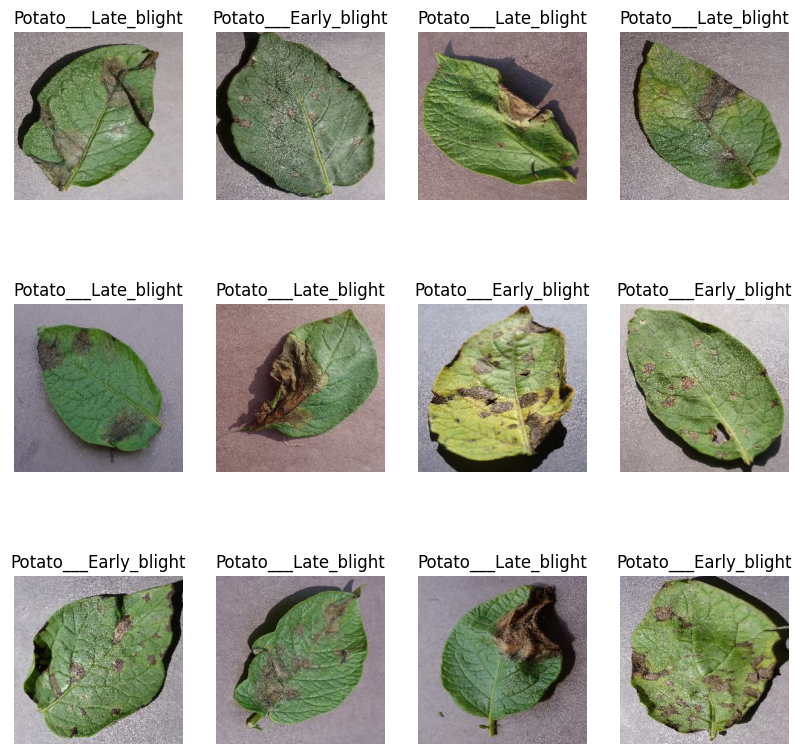

In [4]:
plt.figure(figsize=(10, 10))
for image_batch,label_batch in dataset.take(1):
    #print(image_batch[0].shape)
    #print(image_batch[0].numpy())
    #print(label_batch.numpy())
    #print(label_batch[0].numpy())
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

In [5]:
len(dataset)

68

In [6]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [7]:
train_ds = dataset.take(54)
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, 3)))
for x, y in train_ds:
    print("x.shape:", x.shape)
    print("y.shape:", y.shape)
    break

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
x.shape: (32, 256, 256, 3)
y.shape: (32, 3)


In [8]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [9]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [10]:
val_ds=test_ds.take(6)
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, 3)))
for x, y in val_ds:
    print("x.shape:", x.shape)
    print("y.shape:", y.shape)
    break
# len(val_ds)

x.shape: (32, 256, 256, 3)
y.shape: (32, 3)


In [11]:
test_ds=test_ds.skip(6)
test_ds = test_ds.map(lambda x, y: (x, tf.one_hot(y, 3)))
for x, y in test_ds:
    print("x.shape:", x.shape)
    print("y.shape:", y.shape)
    break
# len(test_ds)

x.shape: (32, 256, 256, 3)
y.shape: (32, 3)


In [12]:
# def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
#     ds_size = len(ds)
#     if shuffle:
#         ds = ds.shuffle(shuffle_size, seed=12)
#     train_size = int(train_split * ds_size)
#     val_size = int(val_split * ds_size)
#     train_ds = ds.take(train_size)    
#     val_ds = ds.skip(train_size).take(val_size)
#     test_ds = ds.skip(train_size).skip(val_size)
    
#     return train_ds, val_ds, test_ds

In [13]:
# train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [14]:
len(train_ds)

54

In [15]:
len(val_ds)

6

In [16]:
len(test_ds)

8

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [19]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2),
  layers.experimental.preprocessing.RandomContrast(0.2),
  layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
])


In [20]:
IMG_SIZE = [256, 256]
model = VGG16(input_shape=IMG_SIZE + [3], weights='imagenet', include_top=False)
for layer in model.layers:
    layer.trainable = False


In [21]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
x = Flatten()(model.output)

In [22]:
from tensorflow.keras.models import Model
prediction = Dense(3, activation='softmax')(x)

# create a model object
custom_model = Model(inputs=model.input, outputs=prediction)

In [23]:
custom_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [24]:
print('Output shape:', custom_model.output_shape)

Output shape: (None, 3)


In [25]:
custom_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
history = custom_model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/8
54/54 [==============================] - 312s 6s/step - loss: 3.5376 - accuracy: 0.8750 - val_loss: 4.0374 - val_accuracy: 0.8177
Epoch 2/8
54/54 [==============================] - 310s 6s/step - loss: 0.4592 - accuracy: 0.9728 - val_loss: 1.9255 - val_accuracy: 0.9375
Epoch 3/8
54/54 [==============================] - 309s 6s/step - loss: 0.3369 - accuracy: 0.9844 - val_loss: 1.0843 - val_accuracy: 0.9635
Epoch 4/8
54/54 [==============================] - 306s 6s/step - loss: 0.1235 - accuracy: 0.9948 - val_loss: 0.8204 - val_accuracy: 0.9479
Epoch 5/8
54/54 [==============================] - 306s 6s/step - loss: 0.1134 - accuracy: 0.9907 - val_loss: 1.4893 - val_accuracy: 0.9688
Epoch 6/8
54/54 [==============================] - 306s 6s/step - loss: 0.0174 - accuracy: 0.9983 - val_loss: 2.3652 - val_accuracy: 0.9427
Epoch 7/8
54/54 [==============================] - 309s 6s/step - loss: 0.0413 - accuracy: 0.9965 - val_loss: 1.0863 - val_accuracy: 0.9688
Epoch 8/8
54/54 [===

In [27]:
scores=custom_model.evaluate(test_ds)

8/8 [==============================] - 39s 4s/step - loss: 0.9520 - accuracy: 0.9698


In [28]:
history.params

{'verbose': 1, 'epochs': 8, 'steps': 54}

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [30]:
history.history['loss'][:5] # show loss for first 5 epochs

[3.53755521774292,
 0.4591684341430664,
 0.3368731737136841,
 0.12346972525119781,
 0.11340979486703873]

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

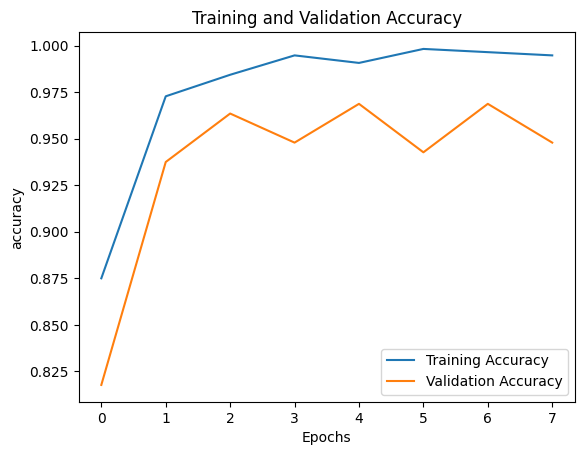

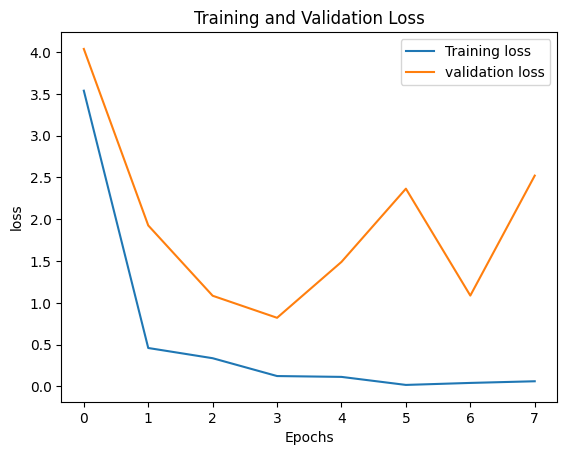

In [33]:
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.show()

plt.plot(range(EPOCHS), loss, label='Training loss')
plt.plot(range(EPOCHS), val_loss, label='validation loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.show()

actual label: Potato___Late_blight
1/1 [==============================] - 8s 8s/step
predicted label: Potato___Late_blight


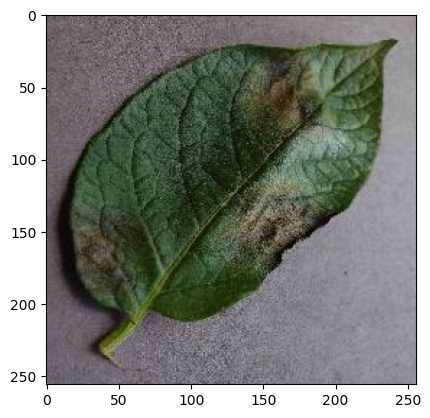

In [45]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    #print(first_label)
    i=0
    for x in first_label:
        if x==1:
            index=i
        i += 1
    #print(index)
    
    plt.imshow(first_image)
    print("actual label:",class_names[index])
    
    batch_prediction = custom_model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

1/1 [==============================] - 8s 8s/step


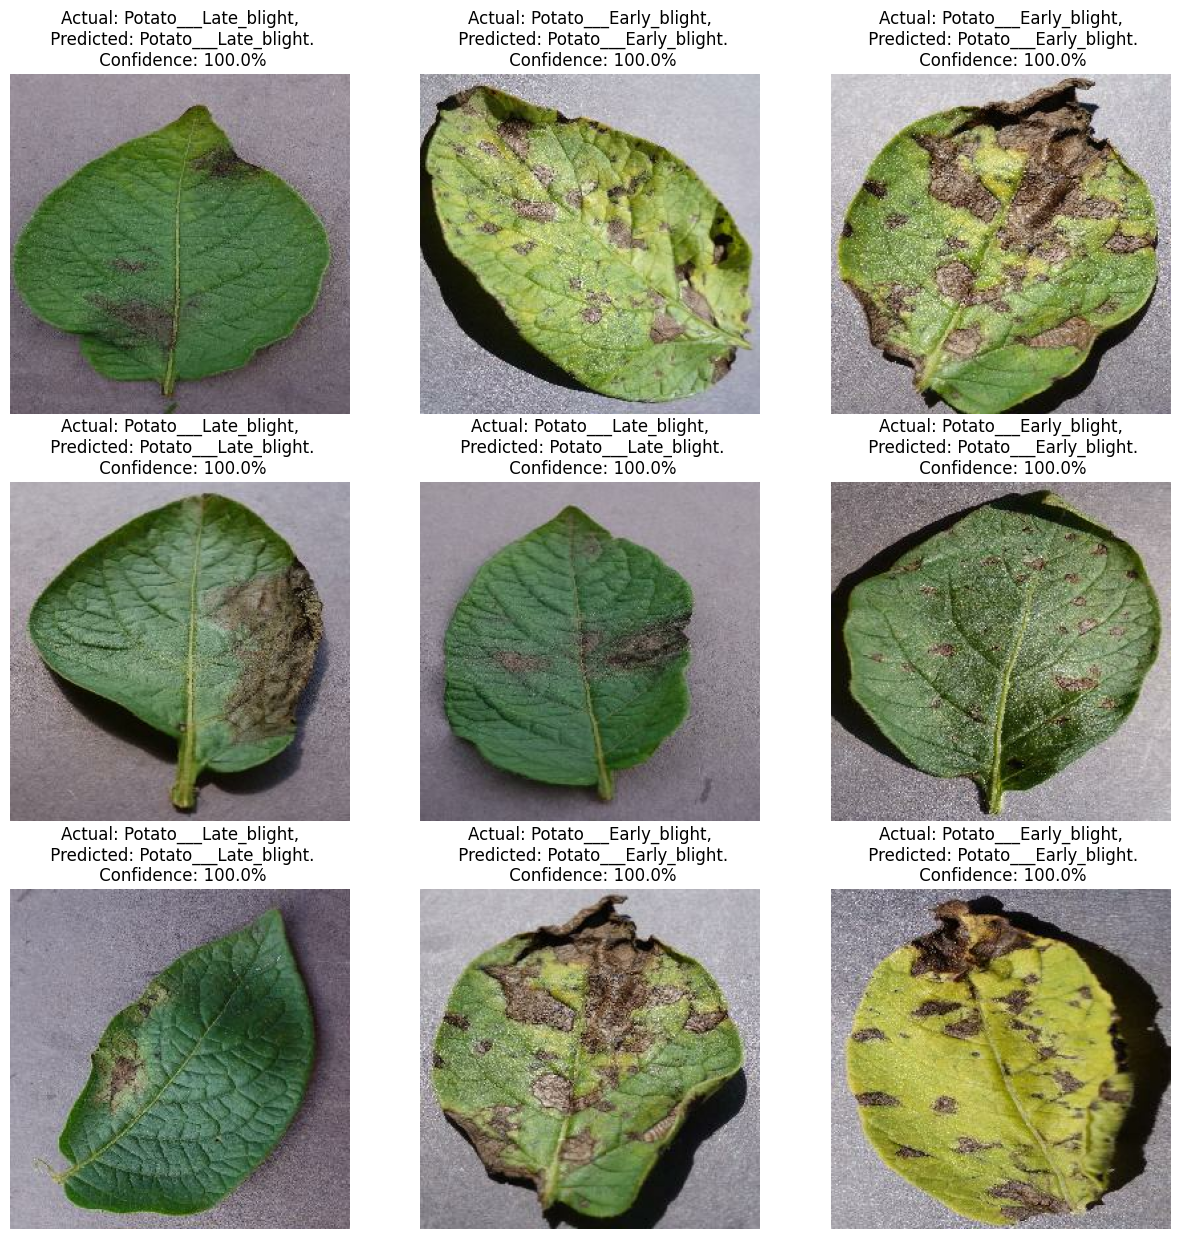

In [46]:
plt.figure(figsize=(15, 15))
for images_batch, labels_batch in test_ds.take(1):
    for i in range(9):
        image = images_batch[i].numpy().astype('uint8')
        label = labels_batch[i].numpy()
        j=0
        for x in label:
            if x==1:
                index=j
            j += 1
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        actual_class=class_names[index]
        batch_prediction = custom_model.predict(images_batch)
        predicted_class=class_names[np.argmax(batch_prediction[i])]
        confidence = round(100 * (np.max(batch_prediction[i])), 2)
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [47]:
import os
model_version= max([int(i) for i in os.listdir("../models")+[0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/3\assets


INFO:tensorflow:Assets written to: ../models/3\assets
